In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
import numpy as np
import os, sys
import pandas as pd
import pybedtools as pb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

LOCAL = False
if LOCAL is True:
    sys.path.append("/Users/sarahfong/tools/py_")
    PATH = "/Users/sarahfong/Desktop/local_data/Biomarin_Jun_2023/"
    RE = os.path.join(PATH, "results")
    CONFIG_NAME="config.local.neuron.mpra.ini"
else:
    PATH="/wynton/group/ahituv/biomarin/data"
    RE = "/wynton/group/ahituv/biomarin/results"
    RE_MAPS = os.path.join(RE, "enh_maps")
    CONFIG_NAME="config.neuron.mpra.orig.ini"
import config_readwrite as crw
import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

In [2]:
config, cfn = crw.read(CONFIG_NAME)

section = 'lib2'
crw.check(config, section)

In [3]:
if "fasta" not in list(config[section]):  # write files to config

    MPRA = os.path.join(PATH, "delta_rank.csv")

    FASTA = os.path.join(PATH, "library_2", "Design",
                         "biomarin-lib2-hg38-final.fasta")
    META_DATA = os.path.join(PATH, "lib2.meta_data.tsv")
    TILE_BED = os.path.join(PATH, "lib2.processed.bed")
    ENH_BED = os.path.join(PATH, 'lib2.processed.merged.bed')
    GREAT_GENE_TSV = os.path.join(PATH, "GREAT", f"region2gene_lib2hg38.tsv")
    DELTA_ACTIVITY = os.path.join(PATH, "deltaMPRA.gaba.minus.glut.tsv")
    DELTA_ACTIVITY_Z = os.path.join(
        PATH, "deltaMPRA.gaba.minus.glut.zscore.tsv")
    SIG_ACTIVITY_Z = os.path.join(PATH, "WilcoxonSig.gaba.glut.zscore.tsv")
    VISTA = os.path.join(PATH, "vista.lib2.tiles.bed")

    # delta MPRA activity
    config[section]["delta.mpra_richa"] = MPRA
    config[section]["delta.mpra_centered"] = DELTA_ACTIVITY
    config[section]["delta.mpra_centeredz"] = DELTA_ACTIVITY_Z

    config[section]["fasta"] = FASTA

    # genome coordinates
    config[section]["tile_bed"] = TILE_BED
    config[section]["enh_bed"] = ENH_BED

    # GREAT
    config[section]["great_nearest"] = GREAT_GENE_TSV

    # meta_data
    config[section]["metadata"] = META_DATA

    # significance GABA v. GLUT
    config[section]["sig-wilcoxon"] = SIG_ACTIVITY_Z

    # vista
    config[section]["vista"] = VISTA
    crw.write(config, cfn)

else:
    MPRA = config[section]["delta.mpra_richa"]
    DELTA_ACTIVITY = config[section]["delta.mpra_centered"]
    DELTA_ACTIVITY_Z = config[section]["delta.mpra_centeredz"]

    FASTA = config[section]["fasta"]

    TILE_BED = config[section]["tile_bed"]
    ENH_BED = config[section]["enh_bed"]

    GREAT_GENE_TSV = config[section]["great_nearest"]
    META_DATA = config[section]["metadata"]

    SIG_ACTIVITY_Z = config[section]["sig-wilcoxon"]
    VISTA = config[section]["vista"]

In [4]:
meta = pd.read_csv(META_DATA, sep='\t')
delta = pd.read_csv(DELTA_ACTIVITY, sep='\t')

len(set(meta["enh.id"]))

1828

# load MPRA data

In [5]:
mpra = pd.read_csv(MPRA)
#mpra = mpra.rename(columns ={"delta.gaba-glut":"delta"})
print(mpra.shape)
mpra.head()

(35371, 5)


,name,gaba_log2_mean,glut_log2_mean,delta,delta_rank
0,chr1:10339772-10340042,-1.602773,0.466691,-2.069465,1.0
1,chr6:154127563-154127833,-0.460660,1.393760,-1.854420,2.0
2,chr4:93216597-93216867,-1.373226,0.426283,-1.799509,3.0
3,chr9:127735295-127735565,-0.784093,1.010851,-1.794944,4.0
4,chr1:31376876-31377146,-0.500106,1.291683,-1.791789,5.0


# evaluate GREAT

- get nearby coordinates using GREAT nearest 2 gene function

## load great annotations

In [6]:
GREAT_GENE = os.path.join(os.path.split(MPRA)[0], "GREAT", f"region2gene_lib2hg38.txt")

locus_dict = {}
with open(GREAT_GENE, "r") as reader:
    for line in reader:
        if "#" not in line and line !="\n":
            
            locus, genes = line.strip("\n").split("\t")  # split on tab to get gene name

            info = [locus]
            
            for n, i in enumerate(genes.split(",")):
                if i != "NONE":
                    gene, dist = i.strip(" ").split(" ")
                    dist = dist.strip("()")
                else:
                    gene, dist = "na", "na"
                
                locus_dict[f'{locus}-{n}'] = [locus, gene, dist]


vstack = np.vstack(locus_dict.values())

great = pd.DataFrame(vstack)
great.columns = ["coor", "gene", 'dist']
great = great.loc[great.dist!="na"]  # remove any elements w/ no genes
great.head()

,coor,gene,dist
0,chr1:101316025-101316295,S1PR1,+79272
1,chr1:101316025-101316295,OLFM3,+530813
2,chr1:101316045-101316315,S1PR1,+79292
3,chr1:101316045-101316315,OLFM3,+530793
4,chr1:101316065-101316335,S1PR1,+79312


# add GREAT annotations to fasta meta data

In [7]:
enh = pd.merge(great, meta, how="right")

# rename columns for merging with MPRA data
enh = enh.rename(columns ={"start":"start.tile",
                           "end":"end.tile"})

enh.head()

,coor,gene,dist,name,sequence,bkgd,72h,ctrl,cl,top_bottom,strand,#chr,start.tile,end.tile,enh.id,enh.name,tile.order
0,chr1:10057-10327,NaN,NaN,chr1:10057-10327,AGGACCGGATCAACTCCCTAACCCTAACCCTAACCCTAACCCTAAC...,False,NaN,NaN,NaN,NaN,+,chr1,10057,10327,chr1:10057-10563,enh.1,0.0
1,chr1:10077-10347,NaN,NaN,chr1:10077-10347,AGGACCGGATCAACTCTAACCCTAACCCTAACCCTAACCCTAACCC...,False,NaN,NaN,NaN,NaN,+,chr1,10077,10347,chr1:10057-10563,enh.1,1.0
2,chr1:10097-10367,NaN,NaN,chr1:10097-10367,AGGACCGGATCAACTAACCCTAACCCAACCCTAACCCTAACCCTAA...,False,NaN,NaN,NaN,NaN,+,chr1,10097,10367,chr1:10057-10563,enh.1,2.0
3,chr1:10117-10387,NaN,NaN,chr1:10117-10387,AGGACCGGATCAACTCCTAACCCTAACCCTAACCCTAACCCTAACC...,False,NaN,NaN,NaN,NaN,+,chr1,10117,10387,chr1:10057-10563,enh.1,3.0
4,chr1:10133-10403,NaN,NaN,chr1:10133-10403,AGGACCGGATCAACTACCCTAACCCTAACCCCTAACCCTAACCCTA...,False,NaN,NaN,NaN,NaN,+,chr1,10133,10403,chr1:10057-10563,enh.1,4.0


# add MPRA

In [8]:
enh = pd.merge(enh, mpra, how="left", left_on="name",
               right_on="name").drop_duplicates()
print(enh.shape)
enh.head()

(72603, 21)


,coor,gene,dist,name,sequence,bkgd,72h,ctrl,cl,top_bottom,...,#chr,start.tile,end.tile,enh.id,enh.name,tile.order,gaba_log2_mean,glut_log2_mean,delta,delta_rank
0,chr1:10057-10327,NaN,NaN,chr1:10057-10327,AGGACCGGATCAACTCCCTAACCCTAACCCTAACCCTAACCCTAAC...,False,NaN,NaN,NaN,NaN,...,chr1,10057,10327,chr1:10057-10563,enh.1,0.0,NaN,NaN,NaN,NaN
1,chr1:10077-10347,NaN,NaN,chr1:10077-10347,AGGACCGGATCAACTCTAACCCTAACCCTAACCCTAACCCTAACCC...,False,NaN,NaN,NaN,NaN,...,chr1,10077,10347,chr1:10057-10563,enh.1,1.0,NaN,NaN,NaN,NaN
2,chr1:10097-10367,NaN,NaN,chr1:10097-10367,AGGACCGGATCAACTAACCCTAACCCAACCCTAACCCTAACCCTAA...,False,NaN,NaN,NaN,NaN,...,chr1,10097,10367,chr1:10057-10563,enh.1,2.0,NaN,NaN,NaN,NaN
3,chr1:10117-10387,NaN,NaN,chr1:10117-10387,AGGACCGGATCAACTCCTAACCCTAACCCTAACCCTAACCCTAACC...,False,NaN,NaN,NaN,NaN,...,chr1,10117,10387,chr1:10057-10563,enh.1,3.0,NaN,NaN,NaN,NaN
4,chr1:10133-10403,NaN,NaN,chr1:10133-10403,AGGACCGGATCAACTACCCTAACCCTAACCCCTAACCCTAACCCTA...,False,NaN,NaN,NaN,NaN,...,chr1,10133,10403,chr1:10057-10563,enh.1,4.0,NaN,NaN,NaN,NaN


In [9]:
enh = pd.merge(enh, delta, how="left", left_on ="name", right_on="name").drop_duplicates()

# remove sequences with no MPRA reads
enh=enh.loc[~enh["delta"].isna()]
enh.shape

(63913, 27)

# add vista

In [10]:
# process overallping vista data

vista = pd.read_csv(VISTA, sep='\t', header=None).drop_duplicates()

# add tile coordinate name
vista["name"] = vista[0] + ':' + vista[1].map(str) + "-" + vista[2].map(str)

# add vista id
vista["vista_id"] = vista[9] + "." + vista[10].map(str).replace(" ", "")
vista["vista_bool"] = True

vista.head()

,0,1,2,3,4,5,6,7,8,9,10,name,vista_id,vista_bool
0,chr1,50633358,50633628,chr1,50633358,50633788,chr1,50633169,50634241,element,197,chr1:50633358-50633628,element.197,True
1,chr1,50633378,50633648,chr1,50633358,50633788,chr1,50633169,50634241,element,197,chr1:50633378-50633648,element.197,True
2,chr1,50633398,50633668,chr1,50633358,50633788,chr1,50633169,50634241,element,197,chr1:50633398-50633668,element.197,True
3,chr1,50633418,50633688,chr1,50633358,50633788,chr1,50633169,50634241,element,197,chr1:50633418-50633688,element.197,True
4,chr1,50633438,50633708,chr1,50633358,50633788,chr1,50633169,50634241,element,197,chr1:50633438-50633708,element.197,True


In [11]:
# vista activity
names = ["vista_id", "vista_activity", "vista_desc"]
use_cols = [3, 6, 7]

# open vista activity dataframe (in hg19 coordinates)
vista_act = pd.read_csv(
    "/wynton/group/ahituv/data/vista/vista_enhancers_hg19.bed", sep='\t', header=None, 
usecols=use_cols, names=names).drop_duplicates()

# clean up whitespace
vista_act["vista_activity"] = vista_act["vista_activity"].apply(lambda x: x.replace(" ", ""))

# reformate id
vista_act["vista_id"] = vista_act["vista_id"].apply(lambda x: ".".join(x.split(" ")[1:-1]))

In [12]:
# merge only the active elements
vista = pd.merge(
    vista, vista_act.loc[vista_act["vista_activity"] == "positive"], how="left", on="vista_id")

In [13]:
# merge enh + vista
enh = pd.merge(enh, vista[["name", "vista_id", "vista_bool", "vista_activity", "vista_desc"]], how = "left")

enh["vista_bool"] = enh["vista_bool"].fillna(False)

# add significance data

In [14]:
sig_reps= pd.read_csv(SIG_ACTIVITY_Z, sep='\t')
print(sig_reps.shape)
sig_reps.head()

(35371, 11)


,name,gaba_1,gaba_2,gaba_3,glut_1,glut_2,glut_3,pval,fdr_bool,fdr,-log10p_fdr
0,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.794103,-2.970164,-2.334829,-1.249982,-1.717908,-2.121743,0.037107,False,0.119390,0.923032
1,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.671559,-2.830269,-2.548998,-1.803647,-3.098993,-0.318147,0.361064,False,0.493535,0.306682
2,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.273753,-2.155235,-2.255196,-2.009413,-2.922402,-0.596232,0.626615,False,0.728743,0.137425
3,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.705924,-2.665966,-2.627832,-0.626111,-2.827502,-1.210420,0.233208,False,0.364764,0.437989
4,"Backgroundseq172hr_top_98|Pos1:115,Pos2:155|Mo...",-2.645673,-2.565910,-3.058675,-2.246619,-1.618896,-3.649946,0.719958,False,0.801537,0.096076


In [15]:
## recompute deltas and sig
enh= pd.merge(enh, sig_reps, how="left").drop_duplicates()
enh["sig"] = enh["fdr"].apply(lambda x: True if x<0.05 else False)

enh["gaba"] = enh[["gaba_1", "gaba_2", "gaba_3"]].mean(axis=1)

enh["glut"] = enh[["glut_1", "glut_2", "glut_3"]].mean(axis=1)
enh["delta.gaba-glut"] = enh["gaba"]-enh["glut"]

In [16]:
# compute elements active in both
enh["cat_both_act"] = False
enh.loc[(enh["gaba-label"]=="activating")&
        (enh["glut-label"]=="activating"), 
       "cat_both_act"] = True

## combine significant ttest and cat_both_act (categorical) labels

In [17]:
enh["sig_n_dif"] = False
enh.loc[(enh["fdr_bool"]==True) & (enh["cat_both_act"]==True), "sig_n_dif"]=True

## scatterplot vista-specific elements

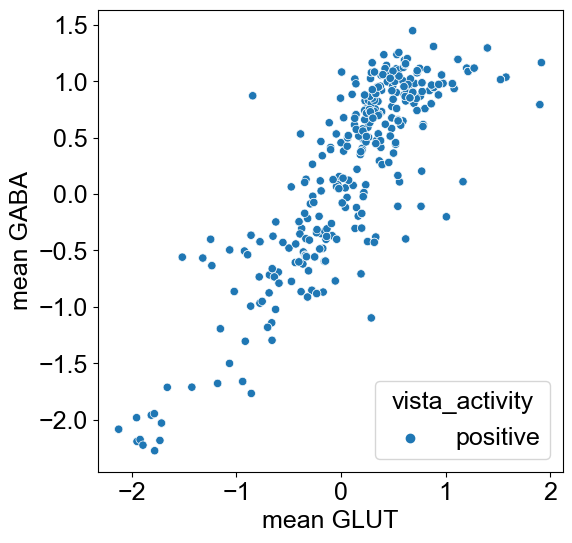

In [18]:
# effect sizes of sig and dif
fig, ax= plt.subplots(figsize=(6,6))
y="gaba" 
x="glut" 
data=enh 
hue="vista_activity"
sns.scatterplot(x=x, y=y, data=data, hue=hue)
out = os.path.join(RE, "vista_bool.scatter.pdf")
ax.set(xlabel="mean GLUT", 
      ylabel="mean GABA")
plt.savefig(out, bbox_inches='tight')

In [19]:
data.loc[data['vista_activity']=="positive"][["gaba", "glut"]].corr()

,gaba,glut
gaba,1.000000,0.822779
glut,0.822779,1.000000


In [20]:
data.loc[data['vista_activity']!="positive"][["gaba", "glut"]].corr()

,gaba,glut
gaba,1.000000,0.736496
glut,0.736496,1.000000


## elements that overlap vista, but are cell type specific

In [21]:
enh.loc[(enh["sig_n_dif"] == True) &
        (enh['vista_bool'] == True), 
        ["name", "gaba", 'glut', "fdr", "cat_both_act", "vista_desc"]].drop_duplicates()

,name,gaba,glut,fdr,cat_both_act,vista_desc


## not cell type specific

In [22]:
enh.loc[(enh["sig_n_dif"] == False) &
        (enh['vista_bool'] == True) &
        (enh["vista_desc"].str.contains("brain")), ["name", "gaba", 'glut', "fdr", "cat_both_act", "vista_desc"]].drop_duplicates()

,name,gaba,glut,fdr,cat_both_act,vista_desc
4508,chr1:164836505-164836775,1.310228,0.885474,0.060581,True,forebrain[4/7] | facial mesenchyme[3/7]
4512,chr1:164836525-164836795,1.187825,0.607518,0.047590,False,forebrain[4/7] | facial mesenchyme[3/7]
4516,chr1:164836545-164836815,1.195401,1.118975,0.849401,True,forebrain[4/7] | facial mesenchyme[3/7]
4520,chr1:164836565-164836835,0.981803,0.704220,0.082012,False,forebrain[4/7] | facial mesenchyme[3/7]
4524,chr1:164836585-164836855,0.982758,0.976571,0.984608,False,forebrain[4/7] | facial mesenchyme[3/7]
...,...,...,...,...,...,...
61998,chr9:127661205-127661475,0.448842,0.333155,0.447661,False,neural tube[4/5] | forebrain[4/5]
62000,chr9:127661225-127661495,0.141061,0.019444,0.198171,False,neural tube[4/5] | forebrain[4/5]
62002,chr9:127661245-127661515,0.165548,0.544250,0.108910,False,neural tube[4/5] | forebrain[4/5]
62004,chr9:127661265-127661535,-0.108246,0.765831,0.109465,False,neural tube[4/5] | forebrain[4/5]


In [23]:
enh.loc[(enh["sig_n_dif"] == False) &
        (enh['vista_bool'] == True) &
        (enh["vista_desc"].str.contains("brain"))].groupby("cat_both_act")['name'].count()

cat_both_act
False    337
True       6
Name: name, dtype: int64

## Rank activity of gaba, glut

In [26]:
# subset dataframe
rank_cols = ["name", 'gaba', "glut", "vista_id", 'vista_bool',
             "vista_desc", "sig", "cat_both_act"]

# remove duplicates, sequences with no MPRA values
ranks = enh[rank_cols].copy().dropna().drop_duplicates()

ranks['glut_rank'] = ranks["glut"].rank(pct=True)
ranks['gaba_rank'] = ranks["gaba"].rank(pct=True)
ranks

,name,gaba,glut,vista_id,vista_bool,vista_desc,sig,cat_both_act,glut_rank,gaba_rank
4508,chr1:164836505-164836775,1.310228,0.885474,element.1191,True,forebrain[4/7] | facial mesenchyme[3/7],False,True,0.907407,0.995726
4509,chr1:164836505-164836775,1.310228,0.885474,element.1191,True,limb[5/8],False,True,0.907407,0.995726
4512,chr1:164836525-164836795,1.187825,0.607518,element.1191,True,forebrain[4/7] | facial mesenchyme[3/7],True,False,0.782051,0.967236
4513,chr1:164836525-164836795,1.187825,0.607518,element.1191,True,limb[5/8],True,False,0.782051,0.967236
4516,chr1:164836545-164836815,1.195401,1.118975,element.1191,True,forebrain[4/7] | facial mesenchyme[3/7],False,True,0.952991,0.972934
...,...,...,...,...,...,...,...,...,...,...
61998,chr9:127661205-127661475,0.448842,0.333155,element.2342,True,neural tube[4/5] | forebrain[4/5],False,False,0.575499,0.458689
62000,chr9:127661225-127661495,0.141061,0.019444,element.2342,True,neural tube[4/5] | forebrain[4/5],False,False,0.347578,0.396011
62002,chr9:127661245-127661515,0.165548,0.544250,element.2342,True,neural tube[4/5] | forebrain[4/5],False,False,0.740741,0.401709
62004,chr9:127661265-127661535,-0.108246,0.765831,element.2342,True,neural tube[4/5] | forebrain[4/5],False,False,0.866097,0.313390


### vista-overlapping elements

In [27]:
ranks.loc[(ranks["vista_bool"] == True) &
          (ranks["vista_desc"].str.contains("brain"))
         ].sort_values(by=["gaba_rank", "glut_rank"], ascending=False)

,name,gaba,glut,vista_id,vista_bool,vista_desc,sig,cat_both_act,glut_rank,gaba_rank
21626,chr15:36948677-36948947,1.449645,0.685712,element.181,True,midbrain (mesencephalon)[4/4],True,False,0.829060,1.000000
4508,chr1:164836505-164836775,1.310228,0.885474,element.1191,True,forebrain[4/7] | facial mesenchyme[3/7],False,True,0.907407,0.995726
4548,chr1:164836678-164836948,1.296786,1.400988,element.1191,True,forebrain[4/7] | facial mesenchyme[3/7],False,True,0.978632,0.990028
21625,chr15:36948657-36948927,1.237964,0.534576,element.181,True,midbrain (mesencephalon)[4/4],True,False,0.735043,0.982906
39759,chr21:37435868-37436138,1.202386,0.634831,element.2333,True,hindbrain (rhombencephalon)[7/7] | forebrain[...,False,False,0.806268,0.977208
...,...,...,...,...,...,...,...,...,...,...
21632,chr15:36948737-36949007,-2.176386,-1.922321,element.181,True,midbrain (mesencephalon)[4/4],False,False,0.011396,0.014245
21629,chr15:36948716-36948986,-2.184830,-1.732644,element.181,True,midbrain (mesencephalon)[4/4],False,False,0.025641,0.011396
21630,chr15:36948717-36948987,-2.193910,-1.951966,element.181,True,midbrain (mesencephalon)[4/4],False,False,0.008547,0.008547
21633,chr15:36948756-36949026,-2.226697,-1.894907,element.181,True,midbrain (mesencephalon)[4/4],False,False,0.014245,0.005698


## get 99th percentile of gaba AND glut

In [23]:
ranks.sort_values(by=["gaba_rank", "glut_rank"], ascending=False)
top99= ranks.loc[(ranks["gaba_rank"]>0.90)&
                 (ranks["glut_rank"]>0.90), 
                ]
print(top99.shape)
top99

enh['rank_top975'] = False
enh.loc[enh["name"].isin(set(top99["name"])), "rank_top975"] = True

enh.loc[(enh['rank_top975']==True) #&
       #(enh["vista_activity"]=="positive")
       ]

(13, 10)


,coor,gene,dist,name,sequence,bkgd,72h,ctrl,cl,top_bottom,...,glut_2,glut_3,pval,fdr_bool,fdr,-log10p_fdr,sig,cat_both_act,sig_n_dif,rank_top975
4508,chr1:164836505-164836775,PBX1,+277005,chr1:164836505-164836775,AGGACCGGATCAACTGCACATAGATTGTTTTCAAGCTCTTGTTTTC...,False,NaN,NaN,NaN,NaN,...,0.782824,0.813545,0.007175,False,0.055866,1.252852,False,True,False,True
4509,chr1:164836505-164836775,PBX1,+277005,chr1:164836505-164836775,AGGACCGGATCAACTGCACATAGATTGTTTTCAAGCTCTTGTTTTC...,False,NaN,NaN,NaN,NaN,...,0.782824,0.813545,0.007175,False,0.055866,1.252852,False,True,False,True
4510,chr1:164836505-164836775,LMX1A,+520075,chr1:164836505-164836775,AGGACCGGATCAACTGCACATAGATTGTTTTCAAGCTCTTGTTTTC...,False,NaN,NaN,NaN,NaN,...,0.782824,0.813545,0.007175,False,0.055866,1.252852,False,True,False,True
4511,chr1:164836505-164836775,LMX1A,+520075,chr1:164836505-164836775,AGGACCGGATCAACTGCACATAGATTGTTTTCAAGCTCTTGTTTTC...,False,NaN,NaN,NaN,NaN,...,0.782824,0.813545,0.007175,False,0.055866,1.252852,False,True,False,True
4516,chr1:164836545-164836815,PBX1,+277045,chr1:164836545-164836815,AGGACCGGATCAACTGTAAATAGAATTTTAAAAACAACAATATCCT...,False,NaN,NaN,NaN,NaN,...,1.422678,0.626405,0.742862,False,0.815414,0.088622,False,True,False,True
4517,chr1:164836545-164836815,PBX1,+277045,chr1:164836545-164836815,AGGACCGGATCAACTGTAAATAGAATTTTAAAAACAACAATATCCT...,False,NaN,NaN,NaN,NaN,...,1.422678,0.626405,0.742862,False,0.815414,0.088622,False,True,False,True
4518,chr1:164836545-164836815,LMX1A,+520035,chr1:164836545-164836815,AGGACCGGATCAACTGTAAATAGAATTTTAAAAACAACAATATCCT...,False,NaN,NaN,NaN,NaN,...,1.422678,0.626405,0.742862,False,0.815414,0.088622,False,True,False,True
4519,chr1:164836545-164836815,LMX1A,+520035,chr1:164836545-164836815,AGGACCGGATCAACTGTAAATAGAATTTTAAAAACAACAATATCCT...,False,NaN,NaN,NaN,NaN,...,1.422678,0.626405,0.742862,False,0.815414,0.088622,False,True,False,True
4532,chr1:164836625-164836895,PBX1,+277125,chr1:164836625-164836895,AGGACCGGATCAACTTTCTTGTCAACATTTTCTTTCTGCATCCCCC...,False,NaN,NaN,NaN,NaN,...,1.115648,1.215434,0.438150,False,0.559320,0.252340,False,False,False,True
4533,chr1:164836625-164836895,PBX1,+277125,chr1:164836625-164836895,AGGACCGGATCAACTTTCTTGTCAACATTTTCTTTCTGCATCCCCC...,False,NaN,NaN,NaN,NaN,...,1.115648,1.215434,0.438150,False,0.559320,0.252340,False,False,False,True


## add direction to  delta values

In [24]:
def responseDirection(df):
    col = "direction"
    df[col] = None
    inspection_cols = [col,
                       'delta.gaba-glut',
                       "gaba",
                       "glut",
                       'gaba_1',
                       'gaba_2',
                       'gaba_3',
                       'glut_1',
                       'glut_2',
                       'glut_3']

    df.loc[(df['gaba'] < 0)
           & (df['glut'] < 0)
           & (df["delta.gaba-glut"] < 0),
           col] = "both negative, GABA<GLUT"  # GABA is more silencing than glut

    df.loc[(df['gaba'] < 0)
           & (df['glut'] < 0)
           & (df["delta.gaba-glut"] > 0),
           col] = "both negative, GLUT<GABA"  # GLUT is more silencing than GABA

    df.loc[(df['gaba'] > 0)
           & (df['glut'] > 0)
           & (df["delta.gaba-glut"] < 0),
           col] = "both positive GLUT>GABA"  # GLUT is more active than GABA

    df.loc[(df['gaba'] > 0)
           & (df['glut'] > 0)
           & (df["delta.gaba-glut"] > 0),
           col] = "both positive GABA>GLUT"  # GABA is more active than GLUT

    df.loc[(df['gaba'] < 0)
           & (df['glut'] > 0)
           & (df["delta.gaba-glut"] < 0),
           col] = "positive GLUT>negative GABA"  # GLUT is active, GABA is not

    df.loc[(df['gaba'] > 0)
           & (df['glut'] < 0)
           & (df["delta.gaba-glut"] > 0),
           col] = "positive GABA>negative GLUT"  # GABA is active, glut is not.

    print("unlabeled", df.loc[df[col].isna(), inspection_cols].shape[0])

    return df.drop_duplicates()

In [25]:
# add direction annotations based on sign of mean GABA, GLUT activity value
enh = responseDirection(enh)

unlabeled 0


### inspect each of the delta calls visually. 
- note there is no case where Glut is positive and GABA is negative. 

# data visualization functions

In [26]:
def getMinDist(df):
    """return str of gene, min distance tuples to gene TSSs per enhancer. 
        Gene TSS annotations from GREAT. 
        note - most enhancers map to two genes, which means two TSSs
    """

    genes = []

    # per gene
    for gene in df["gene"].unique():
        genes.append(gene)
        print(gene)

        # get the gene dataframe
        g = df.loc[(df["gene"] == gene)].copy()

        # if upstream TSS, return min value
        g = g.loc[g["dist"] != "NONE"]
        if len(g) > 0:
            if int(g.dist.min()) > 1:
                genes.append(g.dist.min())

            # elif downstream TSS, return max negative value (min)
            elif int(g.dist.min()) < 1:
                genes.append(g.dist.max())
                
            elif list(set(g.dist)) == "na":
                print(gene,  "TO REMOVE")
                genes = genes[:-1]  # remove gene from list, no distance

    if len(genes) == 0:  # handle cases where no gene is mapped to element.
        genes = ["None"]

    new_genes = []

    for gene in genes:
        new_genes.append(str(gene))

    return "_".join(new_genes)

# nominate candidates

## functions!

In [56]:
def getSupport(enh_id, df):
    """count how many supports there is for differential activity"""
    
    # columns to keep
    t_cols = ["name", 'tile.order', "enh.id", "sig", "cat_both_act", "vista_bool"]
    
    # subset df to enh_id w cols, drop duplicates, copy, and fill na w False
    t = df.loc[df["enh.id"] == enh_id, t_cols].drop_duplicates().copy().fillna(False)
    
    # turn bool into int, into str
    t[t_cols[-3:]]=t[t_cols[-3:]].astype(int)
    
    # str code the support col
    t["support"] =  t["sig"] + t["cat_both_act"] + t["vista_bool"]
    
    # turn int into str
    t[t_cols[-3:]]=t[t_cols[-3:]].astype(str)

    t["support_code"] =  t["sig"] + t["cat_both_act"] + t["vista_bool"]    
    
    t["support_name"] = None
    
    # name codes, so that they are legible
    name_codes = {None:"000", 
                  "cat-only":"010", 
                  "sig-only":"100", 
                  "vs-only":'001',
                  "sig-n-cat":"110", 
                  "sig-n-vs":"101", 
                  "cat-n-vs":"011", 
                  "all": "111"
                 }
    
    for name, code in name_codes.items():
        t.loc[t["support_code"]==code, "support_name"] = name


    return t[["name", "tile.order", "support", "support_code", "support_name"
             ]]

In [57]:
def getSigTileIdDirection(direction, df):
    """return tile ids in direction which 
    (1) have significant activity differences
    (2) have categorical activity differences
    (3) exceed the bootstrapped 95 CIs from delta distribution
    """

    cols = ["vista_bool", 'sig_n_dif_n_bs',
            'direction',
            "name"]

    test = df.loc[(df["vista_bool"] == True) &
                  (df["sig_n_dif_n_bs"] == True),
                  cols].drop_duplicates().copy()

    candidate_set = set(test.loc[test["direction"] == direction, "name"])

    return candidate_set

In [88]:
def getLongFormEnhInfo(df, mpra_celltype):
    """ return dataframes for plotting gaba/glut longform tile activity and significance
        melt the replicate columns
    """
    # do some data formatting, sorting`
    df["tile.order"] = df["tile.order"].astype(int)
    df = df.sort_values(by="tile.order")
    print(list(df))

    # get dataframe of tile.order x significant differences
    sd = pd.melt(df, id_vars="tile.order",
                 value_vars="sig_n_dif_n_bs",
                 value_name="sig"
                 ).drop_duplicates().reset_index()
    sd["y"] = 3
    sd["sig"] = sd["sig"].replace(False, None)
    
    # new variable
    VAR_NAME = "Mean z-score ratio"

    # get replicates of gaba, glut and melt into longform
    if mpra_celltype == "gaba": 
        cols = ["gaba_1", "gaba_2", "gaba_3"]
        
    elif mpra_celltype =="glut":
        cols = ["glut_1", "glut_2", "glut_3"]

    # longform GABA
    longform = pd.melt(df, id_vars="tile.order",
                            value_vars=cols,
                            value_name=VAR_NAME).drop_duplicates().reset_index()

   
    # add back significance column
    longform = pd.merge(longform, sd, how="left", left_on="tile.order",
                             right_on='tile.order').drop(columns=["index_x", "index_y"])

    # add back missing tiles
    longform = addMissingTiles(longform, VAR_NAME)
    
    # change tile.order datatype
    longform["tile.order"]= longform["tile.order"].astype(int)
    
    # fill any missing data w zeros
    longform[VAR_NAME]=longform[VAR_NAME].fillna(0)
    
    
    return longform, VAR_NAME

In [59]:
def getEnhid(tile_coor, df):
    """return enhancer coordinate for tile_id"""
    enh = set(df.loc[df["coor"] == tile_coor, 'enh.id'])

    if len(enh) > 1:
        print("more than one enh_id", enh)

    # return the first (and hopefully only) enh
    return list(enh)[0]

In [60]:
def addMissingTiles(longform, var_name):
    """add back missing tile values for a dataframe"""

    # make an empty dataframe
    empty = pd.DataFrame(
        np.arange(longform["tile.order"].min(),
                  longform["tile.order"].max()+1),
        columns=["tile.order"]
    )
    # add back empty, drop old index
    longform = pd.merge(empty, longform,
                             how="left")
    # fill na
    longform[var_name] = longform[var_name].fillna(0)

    return longform

In [109]:
def plotTile(tile_coor, df, direction, plot_support_annot):

    # get enh_id for tile coordinate
    enh_id = getEnhid(tile_coor, df)

    cols = ["sig_n_dif_n_bs", "glut_1", "glut_2", "glut_3", "gaba_1",
            "gaba_2", "gaba_3", "coor", "enh.id", "enh.name", "tile.order", "gene", "sum_rank", "vista_id", 
           ]

    t = df.loc[df["enh.id"] == enh_id].drop_duplicates().copy()

    # stratify by gene name, as one enhancer may be near two different genes
    enh_name = list(set(t["enh.name"]))[0]
    gene = getMinDist(t)

    # get support for tiles in enhancer
    support = getSupport(enh_id, t)

    t = t[cols]  # subset the dataframe to just these columns

    # make an output file name for tile plot.
    out_line = os.path.join(RE_MAPS, direction,
                            f"{gene}.{enh_name}.line.{plot_support_annot}.pdf")

    # if the outpath does not exist, make it
    if os.path.exists(os.path.join(RE_MAPS, direction)) is False:
        os.mkdir(os.path.join(RE_MAPS, direction))

    # plot line
    longform_gaba, longform_glut, var_name = plot_lineplot(
        t, out_line, enh_id,  enh_name, gene, support, plot_support_annot)

    return t, support, longform_gaba, longform_glut, var_name

# vista, brain

In [33]:
ranks["sum_rank"] = ranks["glut_rank"] + ranks["gaba_rank"]

In [118]:
set(ranks['vista_desc'])

{' branchial arch[4/6] | heart[4/6]',
 ' forebrain[4/7] | facial mesenchyme[3/7]',
 ' heart[5/6] | other[4/6] | liver[4/6]',
 ' hindbrain (rhombencephalon)[3/6] | midbrain (mesencephalon)[5/6]',
 ' hindbrain (rhombencephalon)[7/7] | forebrain[5/7]',
 ' limb[3/9]',
 ' limb[5/8]',
 ' midbrain (mesencephalon)[4/4]',
 ' neural tube[4/5] | forebrain[4/5]',
 ' neural tube[4/5] | hindbrain (rhombencephalon)[4/5] | midbrain (mesencephalon)[4/5]',
 ' neural tube[4/5] | hindbrain (rhombencephalon)[4/5] | midbrain (mesencephalon)[4/5] | liver[3/5]',
 ' neural tube[4/7] | hindbrain (rhombencephalon)[4/7] | midbrain (mesencephalon)[4/7] | forebrain[4/7]',
 ' nose[8/10] | other[7/10]'}

In [34]:
candidates = set(ranks.loc[(ranks["vista_bool"] == True) 
                           &(ranks["vista_desc"].str.contains("brain"))
                           #&(ranks["cat_both_act"]==True)
                           ].sort_values(by=["sum_rank"], ascending=False)["name"])
list(candidates)

['chr1:164836565-164836835',
 'chr8:132413469-132413739',
 'chr8:132414239-132414509',
 'chr8:132415360-132415630',
 'chr8:28513701-28513971',
 'chr15:36949438-36949708',
 'chr8:132413759-132414029',
 'chr15:36949174-36949444',
 'chr1:164836525-164836795',
 'chr8:132414009-132414279',
 'chr21:37436008-37436278',
 'chr15:36948817-36949087',
 'chr15:36948776-36949046',
 'chr1:164836933-164837203',
 'chr15:36949074-36949344',
 'chr15:36948697-36948967',
 'chr1:164836853-164837123',
 'chr1:164836913-164837183',
 'chr8:132413429-132413699',
 'chr15:36949265-36949535',
 'chr15:36949214-36949484',
 'chr15:36949225-36949495',
 'chr9:127661285-127661555',
 'chr8:28513761-28514031',
 'chr8:28513681-28513951',
 'chr15:36948924-36949194',
 'chr8:132413489-132413759',
 'chr21:37435888-37436158',
 'chr15:36948908-36949178',
 'chr15:36948677-36948947',
 'chr8:132413679-132413949',
 'chr1:164836993-164837263',
 'chr9:127661265-127661535',
 'chr8:132414919-132415189',
 'chr2:103402162-103402432',
 'chr

In [110]:
def plot_lineplot(test, out, enh_id,  enh_name, gene_name, support, plot_support_annot):

    test = test.fillna(0)

    # get long form tile activity across replicates for gaba, glut.
    longform_gaba, var_name = getLongFormEnhInfo(test, 'gaba')
    longform_glut, var_name = getLongFormEnhInfo(test, 'glut')

    # set x axis and plot size.
    if len(set(longform_gaba['tile.order'])) > 20:
        fig, ax = plt.subplots(figsize=(12, 4))
    else:
        fig, ax = plt.subplots(figsize=(8, 4))

    # print max scores
    max_gaba, max_glut = longform_gaba[var_name].max(),\
        longform_glut[var_name].max()

    # min scores
    min_gaba, min_glut = longform_gaba[var_name].min(),\
        longform_glut[var_name].min()

    # get max of two for plotting purposes
    max_of_max = max(max_gaba, max_glut)
    min_of_min = min(min_gaba, min_glut)

    if max_of_max < 3.2:
        ymax = 3.2
        ymin = (ymax*-1) - 1
    else:
        ymax = max_of_max + 1
        ymin = (ymax*-1) - 1

    print('max gaba', max_gaba, "max_glut", max_glut)

    # plot longform gaba across enhancer
    sns.pointplot(x="tile.order", y=var_name, data=longform_gaba.fillna(0),
                  label="gaba",
                  join=False,
                  errorbar=("sd"),
                  color="orange", ax=ax)
    plt.setp(ax.collections, alpha=.3)  # alpha

    # plot longform glut activity across enhancer
    sns.pointplot(x="tile.order", y=var_name, data=longform_glut.fillna(0),
                  label="glut",
                  join=False,
                  errorbar=("sd"),
                  color="blue", ax=ax)
    plt.setp(ax.collections, alpha=.3)  # alpha

    ax2 = ax.twinx()

    # support for significance
    support["y"] = ymin + 0.5

    x = "tile.order"
    y = "y"

    data = support

    if plot_support_annot == "support_name":
        hue = "support_name"  # "support"
        hue_order = ["all", "sig-n-bvs", "sig-n-cat",
                     'cat-n-vs', "cat-only", "sig-only", "vs-only"]
        markers = ["*", 'o', "s", "p", ".", "x", "2"]
        marker_title = "sig criteria"
        palette = "tab20b"

    else:
        hue = 'support'
        hue_order = [3, 2, 1]
        markers = ['*', "o", "."]
        marker_title = "sig criteria N"
        palette = "tab10"

    sns.pointplot(x=x, y=y, data=data, hue=hue,
                  hue_order=hue_order,
                  markers=markers,
                  palette=palette,
                  errorbar=None,
                  join=False, ax=ax2,
                  scale=1.5
                  )

    # significance - only if all pass thresholds
    longform_glut = pd.merge(
        longform_glut, test[["tile.order", "sum_rank"]], how="left").drop_duplicates()
    
    longform_glut["y"] = None
    
    longform_glut.loc[longform_glut["sum_rank"] ==
                      longform_glut["sum_rank"].max(), "y"] = "max"
    
    print(longform_glut.loc[longform_glut["sum_rank"] == longform_glut["sum_rank"].max(),
          "tile.order"].unique(), longform_glut["sum_rank"].max())

    sns.pointplot(x="tile.order", y="y", hue="y",
                  data=longform_glut,
                  markers=['*', ".", "x"],
                  color="k",
                  errorbar=None,
                  join=False, ax=ax2
                  )

    # zero line
    ax.axhline(0, c="grey", ls="--")

    vista_id = test["vista_id"].iloc[0]
    # ax title, labels
    ax.set(title=f"{gene_name}bp to TSS\nVISTA-{vista_id}.{enh_id}",
           ylabel="mean z-score",
           ylim=(ymin, ymax)
           )

    ax2.set(ylim=(ymin, ymax),
            ylabel="")

    # Set major ticks for x axis
    ntiles = longform_gaba['tile.order'].max()
    if ntiles >= 100:
        segment = 10
    else:
        segment = 5

    major_xticks = np.arange(0, ntiles, segment)
    ax.set_xticks(major_xticks)

    ax2.set_yticklabels("")
    # legend
    ax.legend(title='key', frameon=False,
              bbox_to_anchor=(0.75, -0.25))
    ax2.legend(title=marker_title, bbox_to_anchor=(1, -0.25), frameon=False)

    # save figure
    plt.savefig(out, bbox_inches="tight")

    plt.show()
    plt.close()

    return longform_gaba, longform_glut, var_name

## dummy cols

In [94]:
enh = pd.merge(enh, ranks[["name", "sum_rank"]], how="left")

enh['cat_both_act']=enh['cat_both_act'].fillna(False)
enh["sig_n_dif_n_bs"] = enh["sig"] + enh['cat_both_act'] + enh["vista_bool"]  # sig celltype dif, both cat active, overlaps vista. 

## Top vista candidates

In [95]:
ranks.loc[ranks.name=='chr15:36948677-36948947']

,name,gaba,glut,vista_id,vista_bool,vista_desc,sig,cat_both_act,glut_rank,gaba_rank,sum_rank
20979,chr15:36948677-36948947,1.467554,0.659318,element.181,True,midbrain (mesencephalon)[4/4],True,False,0.82906,1.0,1.82906


PBX1
LMX1A
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
max gaba 1.443460421913611 max_glut 2.225748644571499
[10] 1.9686609686609686


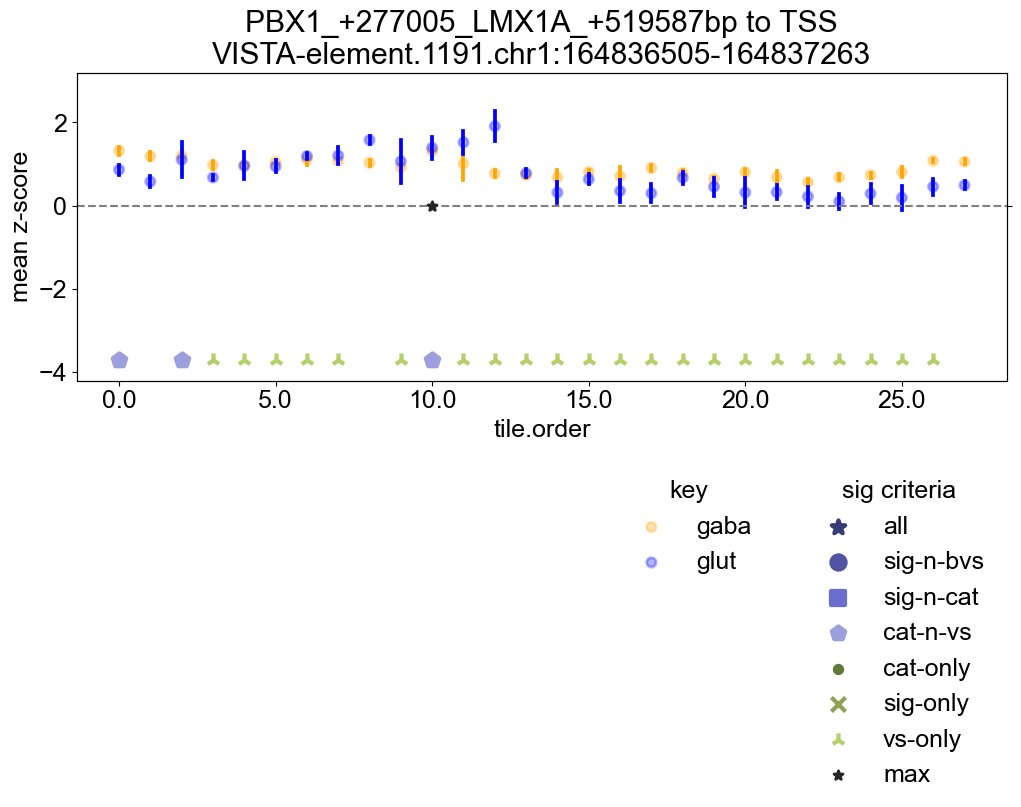

HHLA1
KCNQ3
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
max gaba 1.4579900771200838 max_glut 2.307342573961044
[52] 1.7777777777777777


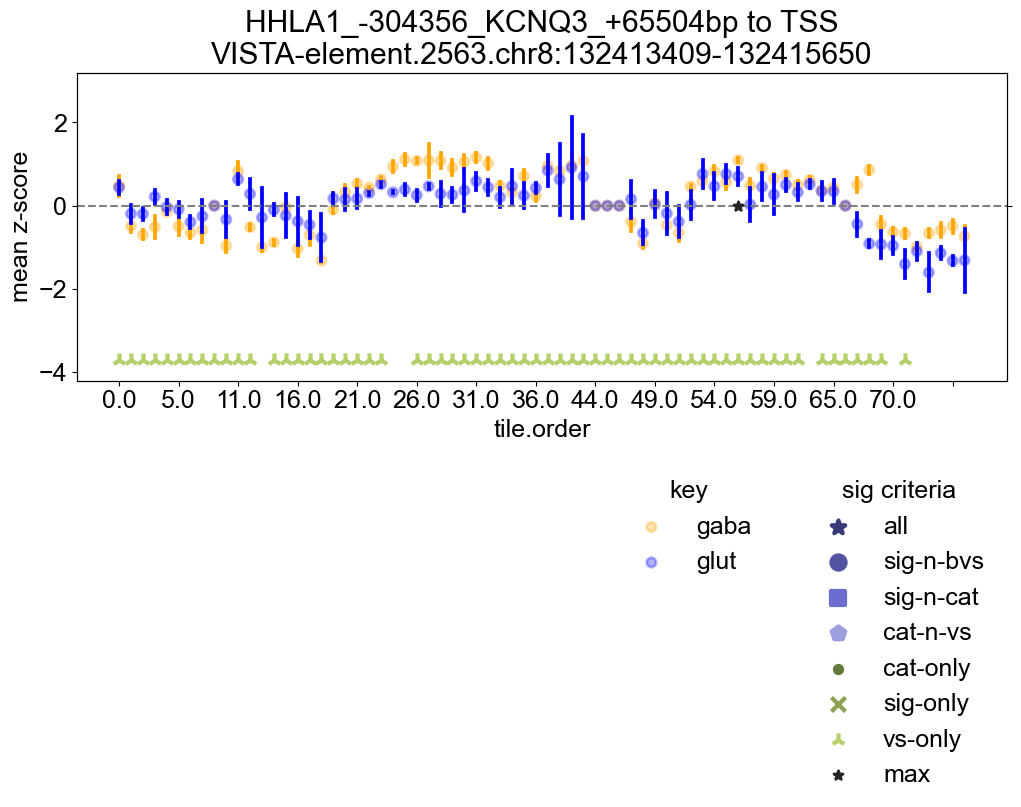

EXTL3
FZD3
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
max gaba 1.2560991198071394 max_glut 1.3354530029789646
[4] 1.9116809116809117


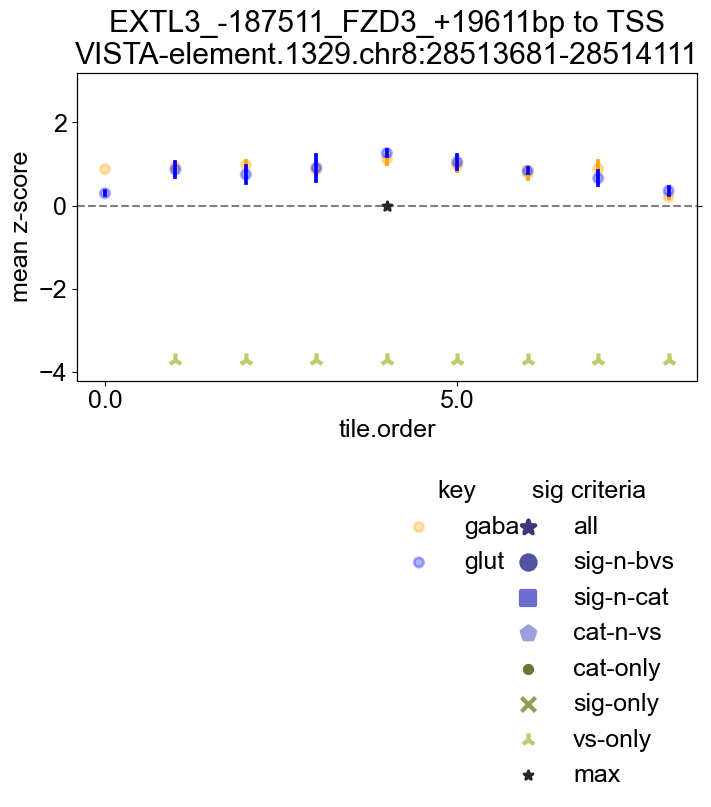

MEIS2
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
max gaba 1.6158554082460574 max_glut 1.145013215336171
[1] 1.8290598290598292


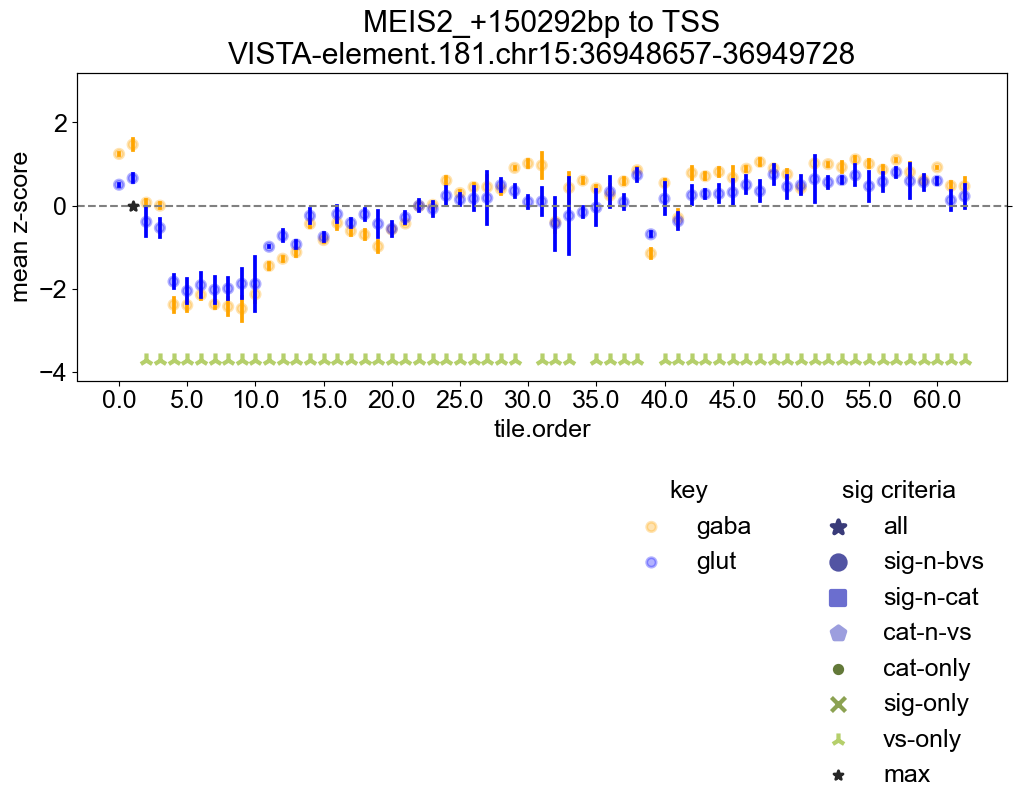

DYRK1A
KCNJ6
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
max gaba 1.2655888069162569 max_glut 1.118087801807417
[0] 1.7834757834757835


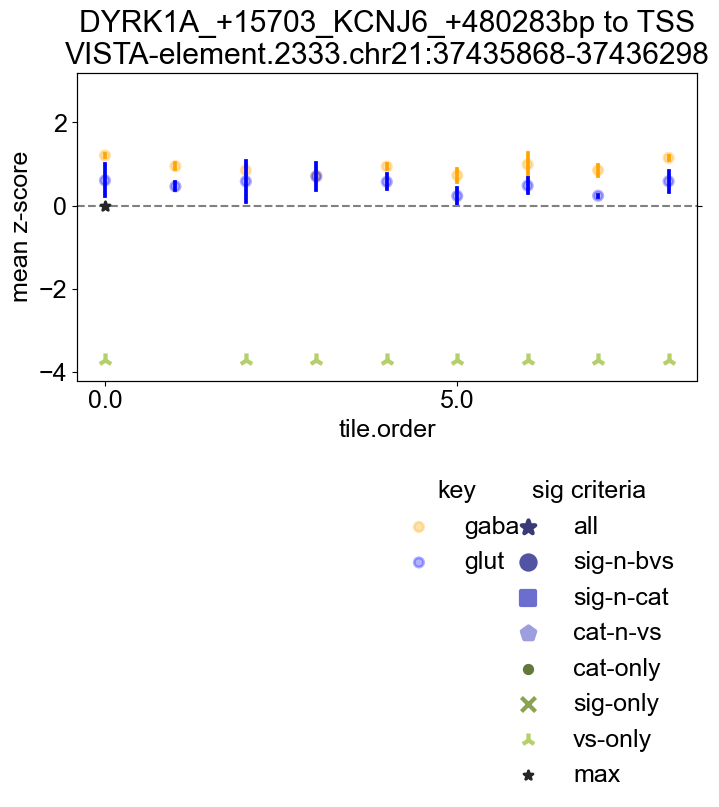

CFAP157
STXBP1
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
max gaba 0.5276149025563718 max_glut 1.2226166324119352
[17] 1.3361823361823362


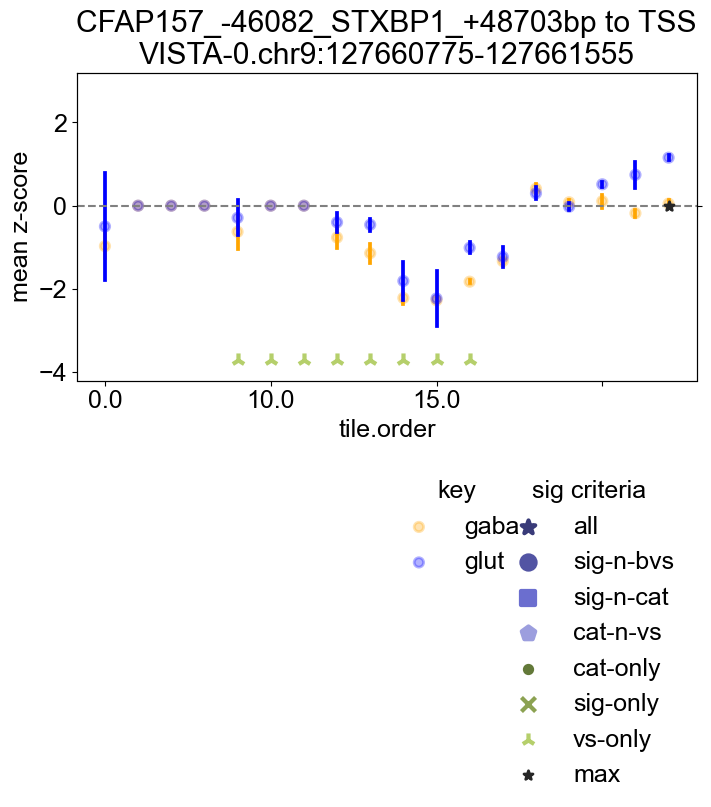

TMEM182
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
max gaba 0.8313030031212563 max_glut 0.9892588904816914
[2] 1.133903133903134


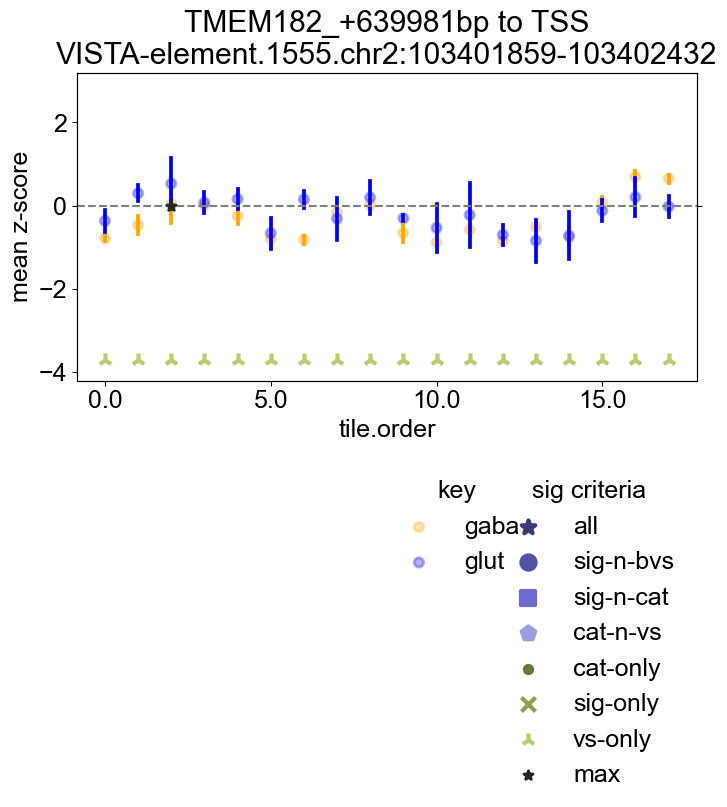

7


In [111]:
TOP_N=15
val = 0
already_run = []
direction='vista'

for tile_id in candidates:
    
    # get corresponding enhancer id
    enh_id = getEnhid(tile_id, enh)
    
    #multiple tiles per enhancer
    if enh_id not in already_run:
        
        # put enhancer data into long form, plot tiles
        t, support, longform_gaba, longform_glut, var_name = plotTile(tile_id, enh, direction, "support_name")
        #t, support, longform_gaba, longform_glut, var_name = plotTile(tile_id, enh, direction, "support")
        already_run.append(enh_id)
        val+=1
        if val >=TOP_N:
            break
print(val)

# SLC6A1, SYNGAP1

In [98]:
# start with genes and enhancer loci
BM_GENES=["SYNGAP1", "SLC6A1"]
bm_targets = set(enh.loc[enh["gene"].isin(BM_GENES), "enh.id"])

chr3:11000975-11001245 chr3:11000975-11001605 BM_GENES
HRH1
SLC6A1
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
max gaba 1.2890290423025903 max_glut 2.378500802771257
[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 16 17] 0.0


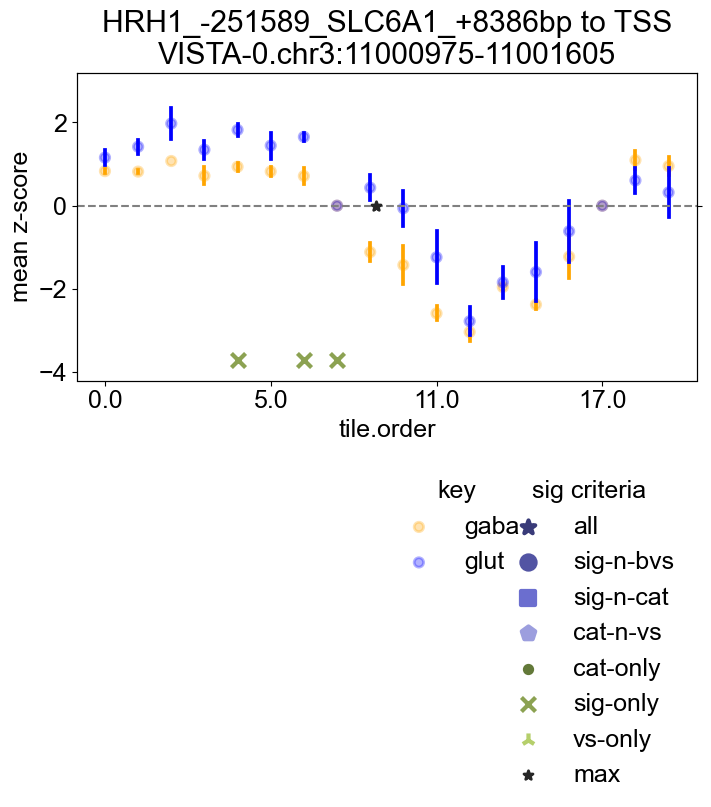

chr3:11010775-11011045 chr3:11010775-11011205 BM_GENES
HRH1
SLC6A1
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
max gaba 1.3912924689359687 max_glut 1.154184600547051
[0 1 2 3 4 5 6 7 8] 0.0


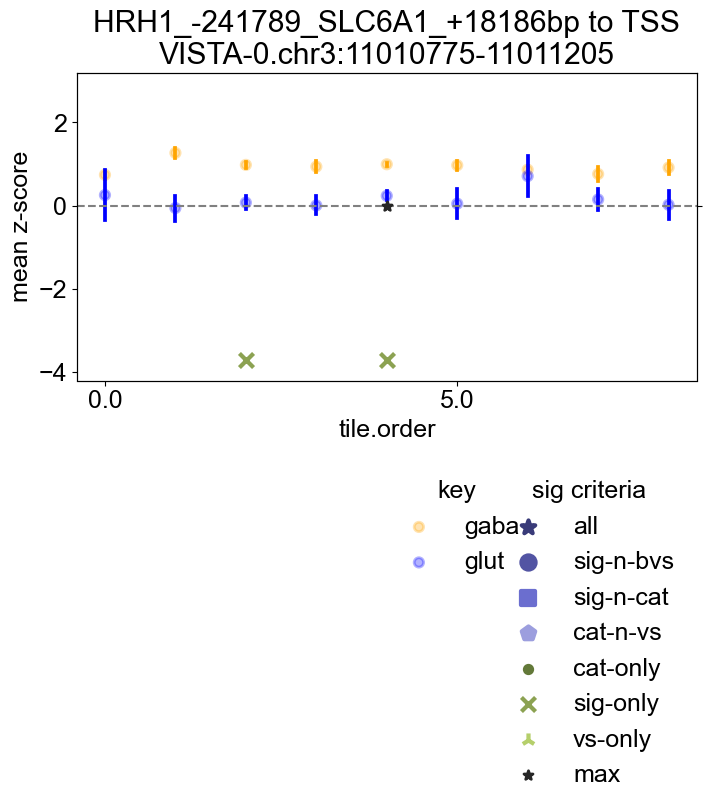

chr6:33417727-33417997 chr6:33417727-33418836 BM_GENES
CUTA
PHF1
SYNGAP1
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
max gaba 1.6145528549961692 max_glut 2.668363730742408
[ 0  2  3  4  5 10 14 15 16 17 18 19 20 22 23 24 25 26 29 31 32 33 34 36
 37 38 40 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70 71 72 73] 0.0


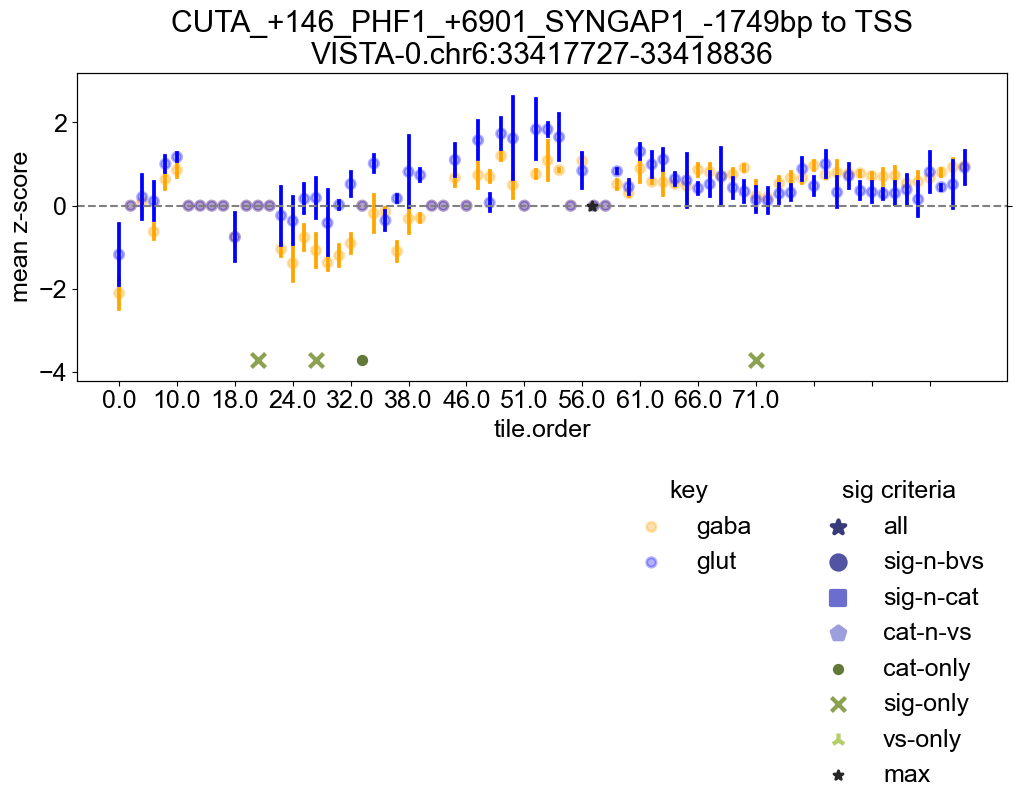

chr3:11010275-11010545 chr3:11010275-11010705 BM_GENES
HRH1
SLC6A1
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
max gaba 1.0769587989911995 max_glut 0.7161100250650806
[0 1 2 3 4 5 6 7 8] 0.0


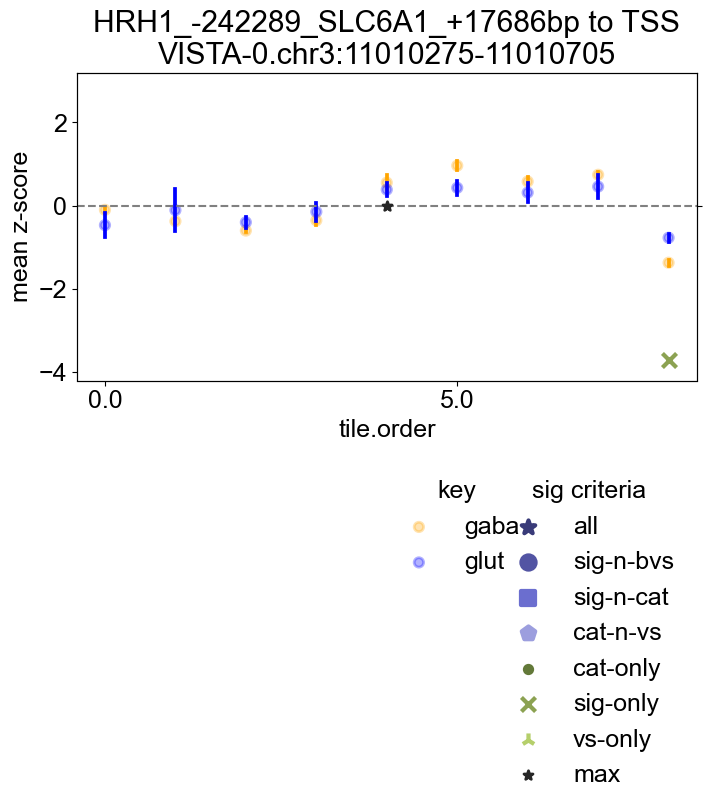

chr3:11016975-11017245 chr3:11016975-11017405 BM_GENES
HRH1
SLC6A1
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
max gaba 0.1518976207831173 max_glut 0.7644489442195873
[0 1 2 3 4 5 6 7 8] 0.0


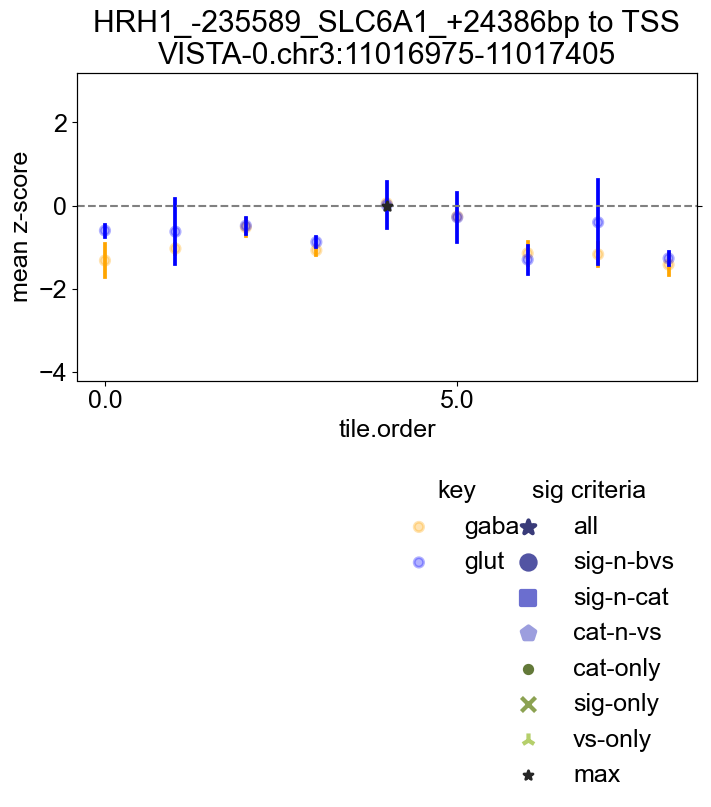

chr3:10972256-10972526 chr3:10972256-10972924 BM_GENES
SLC6A1
SLC6A11
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
max gaba 1.5248751938692562 max_glut 1.5630437573260978
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26] 0.0


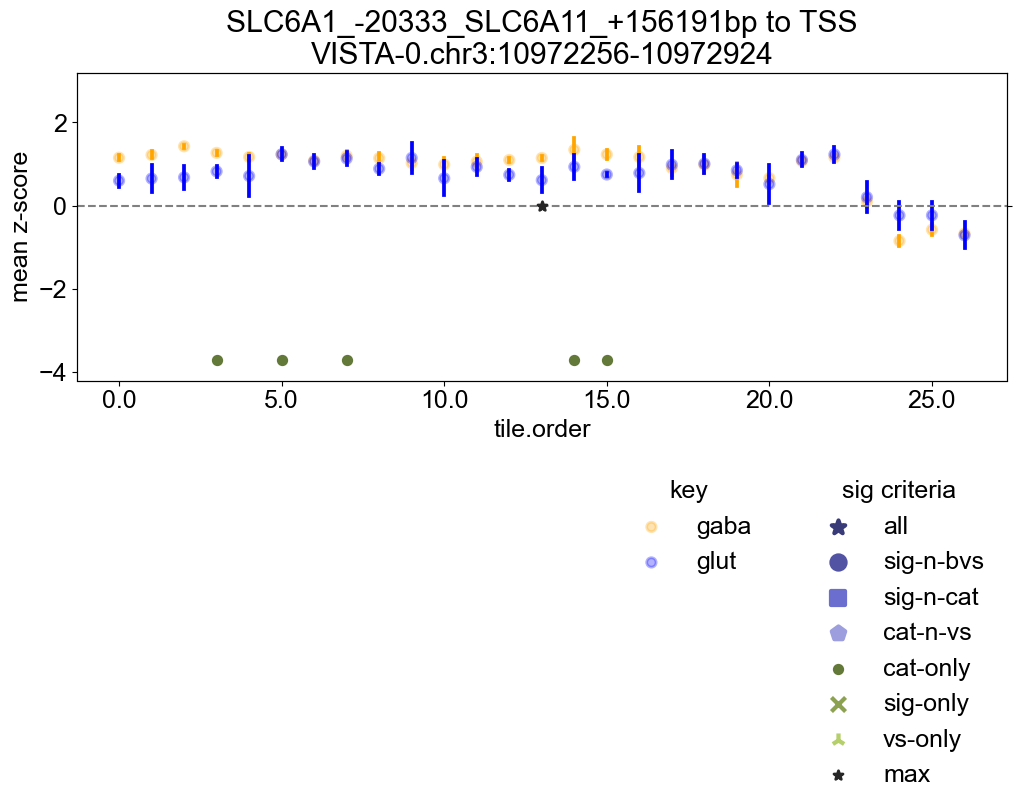

chr3:11014775-11015045 chr3:11014775-11015205 BM_GENES
HRH1
SLC6A1
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
['sig_n_dif_n_bs', 'glut_1', 'glut_2', 'glut_3', 'gaba_1', 'gaba_2', 'gaba_3', 'coor', 'enh.id', 'enh.name', 'tile.order', 'gene', 'sum_rank', 'vista_id']
max gaba 1.1392398093525904 max_glut 0.5184670356876563
[0 1 2 3 4 7 8] 0.0


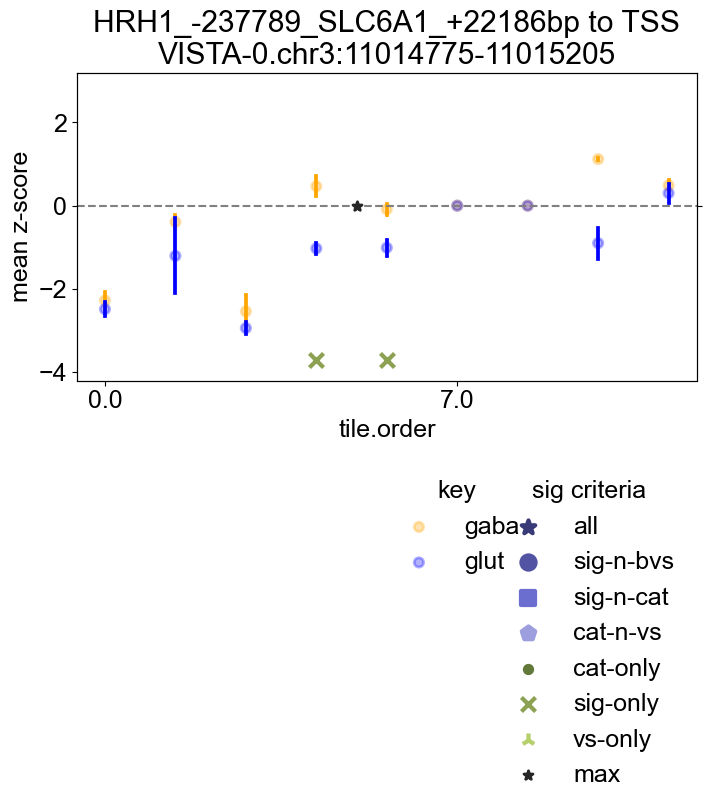

shuffle_105_chr6:33426769-33427039 chr6:33426709-33428145 BM_GENES


IndexError: list index out of range

In [112]:
for enh_id in bm_targets:
    tile_id = enh.loc[enh["enh.id"] == enh_id, "name"].iloc[0]

    direction = "BM_GENES"
    
    print(tile_id, enh_id, direction)
    t, support, longform_gaba, longform_glut, var_name = plotTile(tile_id, enh, direction, "support_name")
    #t, support, longform_gaba, longform_glut, var_name = plotTile(tile_id, enh, direction, "support")


# write candidates to output

## cell-type-specific

In [117]:
candidate_dfg = enh.loc[(enh['name'].isin(candidates))].drop_duplicates()

# label the candidates
candidate_dfg.loc[candidate_dfg["name"].isin(
    candidates), "candidate"] = "vista-overlap"


cols = ['#chr',
        'start.tile',
        'end.tile',
        'candidate',
        "vista_id",
        'vista_desc',
        "sum_rank",
        'gene',
        'dist',
        'enh.id',
        'gaba',
        'glut',
        'delta.gaba-glut',
        'gaba-label',
        'glut-label',
        'cat_both_act',
        'sig',
        'fdr',
        '-log10p_fdr',
        'direction',
        'name',
        'sequence',
        ]

out = os.path.join(RE, "vista.common_active.candidate_tiles.tsv")
candidate_dfg[cols].drop_duplicates().to_csv(out, sep='\t', index=False)

candidate_dfg[cols].head()

,#chr,start.tile,end.tile,candidate,vista_id,vista_desc,sum_rank,gene,dist,enh.id,...,delta.gaba-glut,gaba-label,glut-label,cat_both_act,sig,fdr,-log10p_fdr,direction,name,sequence
4508,chr1,164836505,164836775,vista-overlap,element.1191,forebrain[4/7] | facial mesenchyme[3/7],1.903134,PBX1,+277005,chr1:164836505-164837263,...,0.455515,activating,activating,True,False,0.055866,1.252852,both positive GABA>GLUT,chr1:164836505-164836775,AGGACCGGATCAACTGCACATAGATTGTTTTCAAGCTCTTGTTTTC...
4540,chr1,164836505,164836775,vista-overlap,element.1191,limb[5/8],1.903134,PBX1,+277005,chr1:164836505-164837263,...,0.455515,activating,activating,True,False,0.055866,1.252852,both positive GABA>GLUT,chr1:164836505-164836775,AGGACCGGATCAACTGCACATAGATTGTTTTCAAGCTCTTGTTTTC...
4572,chr1,164836505,164836775,vista-overlap,element.1191,forebrain[4/7] | facial mesenchyme[3/7],1.903134,LMX1A,+520075,chr1:164836505-164837263,...,0.455515,activating,activating,True,False,0.055866,1.252852,both positive GABA>GLUT,chr1:164836505-164836775,AGGACCGGATCAACTGCACATAGATTGTTTTCAAGCTCTTGTTTTC...
4604,chr1,164836505,164836775,vista-overlap,element.1191,limb[5/8],1.903134,LMX1A,+520075,chr1:164836505-164837263,...,0.455515,activating,activating,True,False,0.055866,1.252852,both positive GABA>GLUT,chr1:164836505-164836775,AGGACCGGATCAACTGCACATAGATTGTTTTCAAGCTCTTGTTTTC...
4636,chr1,164836525,164836795,vista-overlap,element.1191,forebrain[4/7] | facial mesenchyme[3/7],1.749288,PBX1,+277025,chr1:164836505-164837263,...,0.611392,activating,False,False,True,0.043771,1.358817,both positive GABA>GLUT,chr1:164836525-164836795,AGGACCGGATCAACTCTCTTGTTTTCATTTCATCAGTAAATAGAAT...
